# Clasificación binaria COVID - No COVID en CT 2D - 3D

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import cv2
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 2. CT-2D SARS-Cov-2

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import cv2
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
root = '/data/DeepSARS/datasets'
data_pd = pd.read_csv(root+'/csv/CT_images_SARS-Cov-2_with_split.csv')
out_save_path = '/home/jota/COVID/models/CT_images_SARS-Cov-2/'
os.makedirs(out_save_path,exist_ok=True)

In [ ]:
data_pd

,folder_name,source,kind,case,view,approval\n,findings,diagnosis,Pulmonary comorbidites,noise,...,crazy paving,interstitial infiltration,Arbol en gemación,pleural effusion,cavitation,others radiological findings,Comorbidites,SDRA,Probabilidad de ser Covid-19 según TAC\n,split
0,/CT_images_volumes/images/SARS-Cov-2/COVID/Cov...,kaggle,CT-2D,NaN,axial,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
1,/CT_images_volumes/images/SARS-Cov-2/COVID/Cov...,kaggle,CT-2D,NaN,axial,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,/CT_images_volumes/images/SARS-Cov-2/COVID/Cov...,kaggle,CT-2D,NaN,axial,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,/CT_images_volumes/images/SARS-Cov-2/COVID/Cov...,kaggle,CT-2D,NaN,axial,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,/CT_images_volumes/images/SARS-Cov-2/COVID/Cov...,kaggle,CT-2D,NaN,axial,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476,/CT_images_volumes/images/SARS-Cov-2/non-COVID...,kaggle,CT-2D,NaN,axial,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2477,/CT_images_volumes/images/SARS-Cov-2/non-COVID...,kaggle,CT-2D,NaN,axial,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2478,/CT_images_volumes/images/SARS-Cov-2/non-COVID...,kaggle,CT-2D,NaN,axial,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2479,/CT_images_volumes/images/SARS-Cov-2/non-COVID...,kaggle,CT-2D,NaN,axial,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test


## Explorando el dataset

In [ ]:
# Número de muestras por diagnostico
c, nc = data_pd.diagnosis.value_counts().values
print('COVID: {} - Non COVID: {}'.format(c, nc))

COVID: 1252 - Non COVID: 1229


In [ ]:
# Número de muestras por diagnostico y por partición
c_train = data_pd[(data_pd.diagnosis==1.0)&(data_pd.split=='train')].shape[0]
nc_train = data_pd[(data_pd.diagnosis==0.0)&(data_pd.split=='train')].shape[0]
c_test = data_pd[(data_pd.diagnosis==1.0)&(data_pd.split=='test')].shape[0]
nc_test = data_pd[(data_pd.diagnosis==0.0)&(data_pd.split=='test')].shape[0]

In [ ]:
print('Train COVID: {} Test COVID: {}'.format(c_train, c_test))
print('Train No COVID: {} Test No COVID: {}'.format(nc_train, nc_test))

Train COVID: 1002 Test COVID: 250
Train No COVID: 983 Test No COVID: 246


### Visualización

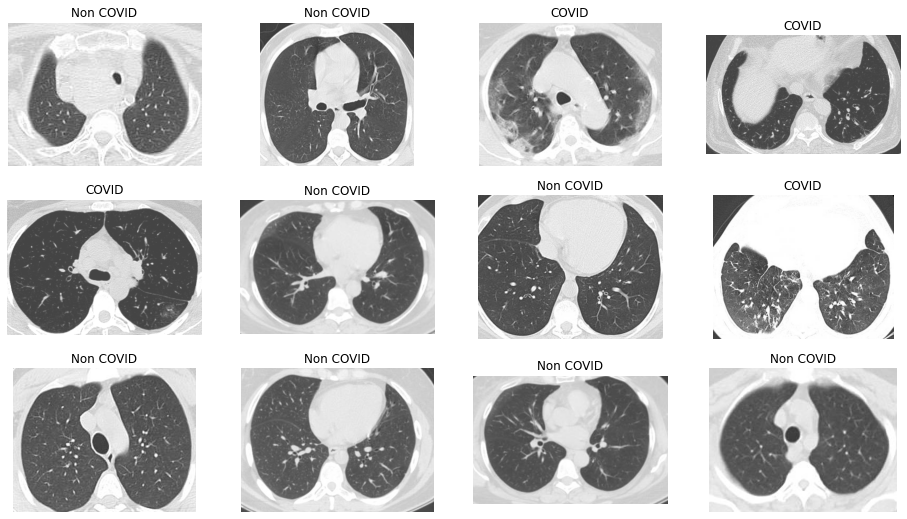

In [ ]:
images_list_index = np.random.choice([i for i in data_pd.index.values], 12)

# create the figura with 4 columns and 3 rows
fig = plt.gcf()
ncols, nrows = 4, 3
fig.set_size_inches(ncols*4, nrows*3)

for i, img_ind in enumerate(images_list_index):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  diagnosis = 'COVID' if data_pd.diagnosis.iloc[img_ind] == 1 else 'Non COVID'
  sp.set_title(diagnosis)
  img = mpimg.imread(root+data_pd.folder_name.iloc[img_ind])
  plt.imshow(img)

plt.show()

### Método de clasificación

In [ ]:
# seleccionamos la GPU
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [ ]:
print(tf.__version__)

2.2.0


### Cargar y fijar los hiperparametros

In [ ]:
CHANNELS = 3
IMG_SIZE = 224
BATCH_SIZE = 16
DATA_PATH = '/data/DeepSARS/datasets/tf_records/CT-2D-SARS-Cov-2/'

In [ ]:
encoding_dictionary = {
        'diagnosis': tf.io.FixedLenFeature([], tf.int64), # 0 -> No Covid, 1 -> Covid
        'height': tf.io.FixedLenFeature([], tf.int64), # Height of the image
        'width': tf.io.FixedLenFeature([], tf.int64), # Width of the image
        'channels': tf.io.FixedLenFeature([], tf.int64), # Channels of the image, generally is 3
        'img': tf.io.FixedLenFeature([], tf.string) # The image data itself
    }

### Leer los datos

In [ ]:
TRAIN_PATH = os.path.join(DATA_PATH, 'CT-2D-SARS-Cov-2_train.tfrecord')
TEST_PATH = os.path.join(DATA_PATH, 'CT-2D-SARS-Cov-2_test.tfrecord')

#raw_train = tf.data.TFRecordDataset(TRAIN_PATH)
raw_test = tf.data.TFRecordDataset(TEST_PATH)

In [ ]:
def from_bytes_to_dict(example_bytes):
    return tf.io.parse_single_example(example_bytes, encoding_dictionary)

def extract_data_from_dict(img_features):
    img = tf.io.decode_raw(img_features['img'], tf.uint8)
    img = tf.reshape(img, (img_features["height"], img_features["width"], img_features["channels"]))
    diagnosis = img_features["diagnosis"]
    return img, diagnosis

#raw_train = raw_train.map(from_bytes_to_dict, -1).map(extract_data_from_dict, -1)
raw_test = raw_test.map(from_bytes_to_dict, -1).map(extract_data_from_dict, -1)

raw_test

<ParallelMapDataset shapes: ((None, None, None), ()), types: (tf.uint8, tf.int64)>

In [ ]:
def format_example(image, diagnosis):
    image = tf.cast(image, tf.float32)
    image = (image / 255.)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    return image, tf.one_hot(diagnosis,2)

#formatted_train = raw_train.map(format_example, -1)
formatted_test = raw_test.map(format_example, -1)

formatted_test

<ParallelMapDataset shapes: ((224, 224, None), (2,)), types: (tf.float32, tf.float32)>

### Aumento de imágenes

In [ ]:
def rot(image,diagnosis):
  image = tf.image.rot90(image, k=3)
  return image,diagnosis

def flip(image,diagnosis):
  image = tf.image.flip_left_right(image)
  return image,diagnosis

### División de los datos

In [ ]:
!mkdir -p ../cache
#train_batches = formatted_train_rot_flip.cache('../cache/CT-2D-SARS-Cov-2').shuffle(138, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(10)
test_batches = formatted_test.cache().shuffle(138, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(10)

In [ ]:
# rectificando train
data = tf.data.TFRecordDataset(os.path.join(TRAIN_PATH))
data_dict = data.map(from_bytes_to_dict, -1)
total_data = data_dict.map(extract_data_from_dict, -1)
total_data = total_data.map(format_example,-1)

total_data_train_augment_rot = total_data.map(rot, -1)
total_data_train_augment_flip = total_data.map(flip, -1)

formatted_train_rot = total_data.concatenate(total_data_train_augment_rot)
formatted_train_rot_flip = formatted_train_rot.concatenate(total_data_train_augment_flip)
train_batches = formatted_train_rot_flip.cache().shuffle(138, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(10)

In [ ]:
c = 0
for x,y in train_batches:
    #print(x.shape)
    c = c+1
c

373

### Modelo base a partir de una Convnet pre-entrenada

In [ ]:
base_model_name = 'ResNet152'
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)
num_clases = 2
activation = 'sigmoid'

In [ ]:
def transfer_learning(base_model, num_clases, activation):
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu', name='dense_pen')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(num_clases, activation=activation)(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers[:27]:
        layer.trainable = True
    for layer in base_model.layers[27:]:
        layer.trainable = True
    return model

def make_model(base_model_name, IMG_SHAPE):
    if base_model_name == 'InceptionV3':
        from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
        base_model = InceptionV3(weights='imagenet',include_top=False,input_shape=IMG_SHAPE)
    elif base_model_name == 'InceptionV4':
        from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
        base_model = InceptionResNetV2(weights='imagenet',include_top=False,input_shape=IMG_SHAPE)
    elif base_model_name == 'ResNet152':
        from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
        base_model = ResNet152(weights='imagenet',include_top=False,input_shape=IMG_SHAPE)
    return base_model, preprocess_input

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

base_model, preprocess_input = make_model(base_model_name, IMG_SHAPE)
# realizar el llamado a trasfer learning
finetune_model = transfer_learning(base_model, num_clases, activation)

234700800/234698864 [==============================] - 10s 0us/step


In [ ]:
base_learning_rate = 0.000001
adam_optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

finetune_model.compile(optimizer=adam_optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
                  tf.keras.metrics.AUC(name='auc', multi_label=False),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall')
              ])

In [ ]:
finetune_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
loss0, bin_accuracy0, auc0, precision0, recall0 = finetune_model.evaluate(train_batches)

373/373 [==============================] - 41s 111ms/step - loss: 0.2434 - binary_accuracy: 0.9485 - auc: 0.9901 - precision: 0.9441 - recall: 0.9535


In [ ]:
loss0, bin_accuracy0, auc0, precision0, recall0 = finetune_model.evaluate(test_batches)

31/31 [==============================] - 3s 109ms/step - loss: 0.2648 - binary_accuracy: 0.9264 - auc: 0.9847 - precision: 0.9222 - recall: 0.9315


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial binary accuracy: {:.2f}".format(bin_accuracy0))
print("initial AUC: {:.2f}".format(auc0))
print("initial precision: {:.2f}".format(precision0))
print("initial recall: {:.2f}".format(recall0))

initial loss: 0.26
initial binary accuracy: 0.93
initial AUC: 0.98
initial precision: 0.92
initial recall: 0.93


In [ ]:
import math

def decay(epoch):
    init_lr = base_learning_rate
    factor = 0.1
    return init_lr * (factor ** epoch)

def step_decay(epoch):
    init_lr = base_learning_rate
    drop = 0.1
    epochs_drop = 15
    lrate = init_lr * math.pow(drop,math.floor((1+epoch)/epochs_drop))

    return lrate


#decay_lr = tf.keras.callbacks.LearningRateScheduler(decay, verbose=1)
decay_lr = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [ ]:
initial_epochs = 20

history = finetune_model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=test_batches,
                    callbacks=[decay_lr])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/20
373/373 [==============================] - 150s 403ms/step - loss: 0.7613 - binary_accuracy: 0.4950 - auc: 0.4923 - precision: 0.4946 - recall: 0.4544 - val_loss: 1.1788 - val_binary_accuracy: 0.4960 - val_auc: 0.4916 - val_precision: 0.4960 - val_recall: 0.5000 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 2/20
373/373 [==============================] - 152s 407ms/step - loss: 0.7344 - binary_accuracy: 0.5141 - auc: 0.5243 - precision: 0.5143 - recall: 0.5081 - val_loss: 0.9797 - val_binary_accuracy: 0.5131 - val_auc: 0.4872 - val_precision: 0.5150 - val_recall: 0.4496 - lr: 1.0000e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 3/20
373/373 [==============================] - 152s 407ms/step - loss: 0.7040 - binary_accuracy: 0.5468 - auc: 0.5723 - precision: 0.5469 - recall: 0.5456 - val_loss: 0.6713 - val_binary_accuracy: 0.5897 

### Gráficas de rendimiento

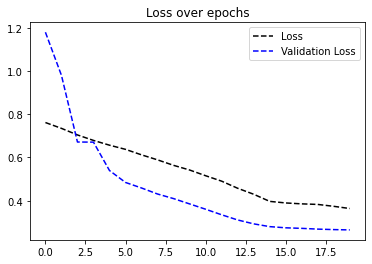

In [ ]:
fig = plt.figure()
plt.plot(history.history["loss"],'k--')
plt.plot(history.history["val_loss"],'b--')
plt.title('Loss over epochs')
plt.legend(labels=["Loss","Validation Loss"])
plt.show()

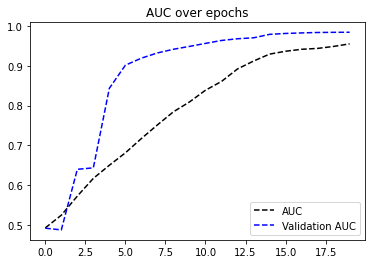

In [ ]:
fig = plt.figure()
plt.plot(history.history["auc"],'k--')
plt.plot(history.history["val_auc"],'b--')
plt.title('AUC over epochs')
plt.legend(labels=["AUC","Validation AUC"])
plt.show()

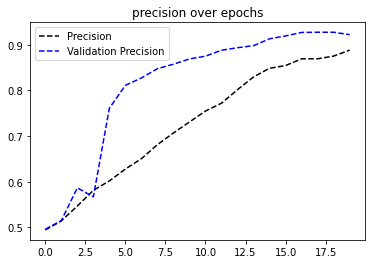

In [ ]:
fig = plt.figure()
plt.plot(history.history["precision"],'k--')
plt.plot(history.history["val_precision"],'b--')
plt.title('precision over epochs')
plt.legend(labels=["Precision","Validation Precision"])
plt.show()

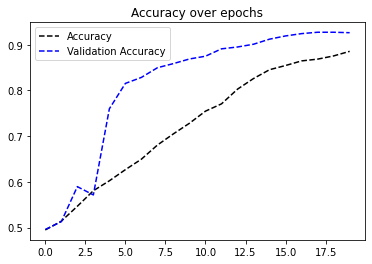

In [ ]:
fig = plt.figure()
plt.plot(history.history["binary_accuracy"],'k--')
plt.plot(history.history["val_binary_accuracy"],'b--')
plt.title('Accuracy over epochs')
plt.legend(labels=["Accuracy","Validation Accuracy"])
plt.show()

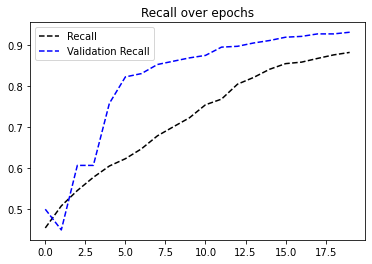

In [ ]:
fig = plt.figure()
plt.plot(history.history["recall"],'k--')
plt.plot(history.history["val_recall"],'b--')
plt.title('Recall over epochs')
plt.legend(labels=["Recall","Validation Recall"])
plt.show()

### Evaluar en test

In [ ]:
test_scores = finetune_model.evaluate(test_batches)

31/31 [==============================] - 3s 109ms/step - loss: 0.2648 - binary_accuracy: 0.9264 - auc: 0.9847 - precision: 0.9222 - recall: 0.9315


In [ ]:
loss, _, auc, _, _ = test_scores

In [ ]:
auc

0.9846757650375366

### Calculo del AUC score

In [ ]:
target_names = ['Non Covid', 'Covid']

In [ ]:
test_set = list(formatted_test.as_numpy_iterator())

In [ ]:
test_images = np.asarray([sample[0] for sample in test_set])
test_labels = np.asarray([sample[1] for sample in test_set])

In [ ]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate

logits = finetune_model.predict(test_images)
y_pred_class = np.argmax(logits, axis=1)
predicted_class_probab=np.max(logits,axis=1)
print('Confusion Matrix')
table = confusion_matrix(np.argmax(test_labels, axis=1),y_pred_class).tolist()
table[0].insert(0, target_names[0])
table[1].insert(0, target_names[1])
print(tabulate(table, headers=target_names, tablefmt="pretty"))
print('\nClassification Report')
table2 = classification_report(np.argmax(test_labels, axis=1), y_pred_class, target_names=target_names)
print(table2)

Confusion Matrix
+-----------+-----------+-------+
|           | Non Covid | Covid |
+-----------+-----------+-------+
| Non Covid |    242    |   4   |
|   Covid   |    32     |  218  |
+-----------+-----------+-------+

Classification Report
              precision    recall  f1-score   support

   Non Covid       0.88      0.98      0.93       246
       Covid       0.98      0.87      0.92       250

    accuracy                           0.93       496
   macro avg       0.93      0.93      0.93       496
weighted avg       0.93      0.93      0.93       496



### Confusion matrix tf

In [ ]:
logits = finetune_model.predict(test_images)
y_pred_class = np.argmax(logits, axis=1)
predicted_class_probab=np.max(logits,axis=1)
print('Confusion Matrix')
matrix = tf.math.confusion_matrix(np.argmax(test_labels, axis=1), y_pred_class).numpy()
matrix

Confusion Matrix


array([[242,   4],
       [ 32, 218]], dtype=int32)

### Specificity and f1-score

In [ ]:
tn, fp, fn, tp = confusion_matrix(np.argmax(test_labels, axis=1),y_pred_class).ravel()

accuracy = (tp+tn)/(tp+fp+tn+fn)

specificity = tn / (tn+fp)

precision = tp / (tp+fp)

recall = tp/(tp+fn)

fscore = 2*((precision*recall)/(precision+recall))

print('Acc {}'.format(accuracy))
print('specificity {}'.format(specificity))
print('precision {}'.format(precision))
print('recall {}'.format(recall))
print('fscore {}'.format(fscore))

Acc 0.9274193548387096
specificity 0.983739837398374
precision 0.9819819819819819
recall 0.872
fscore 0.923728813559322


### Curva roc

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.argmax(test_labels, axis=1), logits[:,1], pos_label=1)
fpr.shape, tpr.shape, metrics.auc(fpr, tpr)

((54,), (54,), 0.9839512195121951)

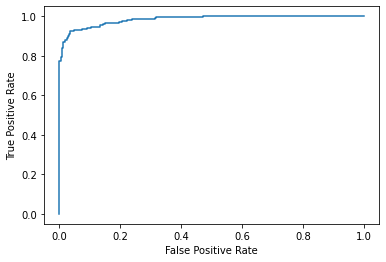

In [ ]:
plt.plot(fpr,tpr);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

### TSNE

In [ ]:
 # Model getting the last full connected before softmax
model_tsne = tf.keras.Model(inputs=finetune_model.inputs, outputs=[finetune_model.get_layer("dense_pen").output])
# In this case test_data contain all the train and test data, PLEASE FOR TRAIN AND TEST DATA GET THAT VECTORS
tsne_predictions = model_tsne.predict(test_images)
tsne_predictions.shape

(496, 1024)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3,learning_rate=100,random_state=8128, n_jobs=-1)
points_tsne = tsne.fit_transform(tsne_predictions)
print(points_tsne.shape)
tsne

(496, 3)


TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=100,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=3, n_iter=1000, n_iter_without_progress=300, n_jobs=-1,
     perplexity=30.0, random_state=8128, verbose=0)

### unir datos

In [ ]:
# load model
finetune_model = tf.keras.models.load_model('/home/jota/COVID/models/CT_images_SARS-Cov-2/0001-Bivlab-ResNet152-CT-2D-SARS-Cov-2/0001-Bivlab-ResNet152-CT-2D-SARS-Cov-2_model.h5')

In [ ]:
# rectificando train
data = tf.data.TFRecordDataset(os.path.join(TRAIN_PATH))
data_dict = data.map(from_bytes_to_dict, -1)
total_data = data_dict.map(extract_data_from_dict, -1)
total_data = total_data.map(format_example,-1)
train_batches = total_data.cache().shuffle(138, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(10)

In [ ]:
labels_test = []
predictions_test = []
for x,y in test_batches:
    for x_i in finetune_model.predict(x):
        predictions_test.append(x_i)
    for y_i in y:
        labels_test.append(y_i.numpy())
labels_test = np.r_[labels_test]
predictions_test = np.r_[predictions_test]
predicted_test = np.argmax(predictions_test, axis=1)

In [ ]:
labels_train = []
predictions_train = []
for x,y in train_batches:
    for x_i in finetune_model.predict(x):
        predictions_train.append(x_i)
    for y_i in y:
        labels_train.append(y_i.numpy())
labels_train = np.r_[labels_train]
predictions_train = np.r_[predictions_train]
predicted_train = np.argmax(predictions_train, axis=1)

In [ ]:
total_labels = np.concatenate([labels_train,labels_test], axis=0)
total_labels.shape

(2481, 2)

In [ ]:
predictions_train.shape, predictions_test.shape

((1985, 2), (496, 2))

In [ ]:
class_0 = np.concatenate([np.squeeze(predictions_train[:,0]), np.squeeze(predictions_test[:,0])])
class_1 = np.concatenate([np.squeeze(predictions_train[:,1]), np.squeeze(predictions_test[:,1])])
total_predictions = np.vstack((class_0,class_1)).T

class_0.shape, class_1.shape, total_predictions.shape

((2481,), (2481,), (2481, 2))

In [ ]:
total_predictions.mean(axis=0).shape, total_predictions.std(axis=0).shape

((2,), (2,))

In [ ]:
len(total_predictions.tolist())

2481

### UMAP

In [ ]:
train_set = list(total_data.as_numpy_iterator())
train_images = np.asarray([sample[0] for sample in train_set])
train_labels = np.asarray([sample[1] for sample in train_set])

In [ ]:
np.vstack((train_images, test_images)).shape

(2481, 224, 224, 3)

In [ ]:
 # Model getting the last full connected before softmax
model_umap = tf.keras.Model(inputs=finetune_model.inputs, outputs=[finetune_model.get_layer("dense_pen").output])
# In this case test_data contain all the train and test data, PLEASE FOR TRAIN AND TEST DATA GET THAT VECTORS
umap_predictions = model_umap.predict(np.vstack((train_images, test_images)))

In [ ]:
umap_predictions.shape

(2481, 2048)

In [ ]:
from umap import UMAP
transformer = UMAP(n_neighbors=20,
        min_dist=0.5,
        n_components=3,
        metric='euclidean',
        #metric='rogerstanimoto',
        transform_seed=8128)
points_umap = transformer.fit_transform(umap_predictions)
print(points_umap.shape)
transformer

(2481, 3)


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.5, n_components=3, n_epochs=None,
     n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=8128, unique=False,
     verbose=False)

### Pickle

In [ ]:
import pickle

metrics = {
    "umap": transformer,
    "metrics":{
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1_score": fscore,
        "auc": auc,
        "samples": 2481,
        "patients": 60,
        "epochs": initial_epochs,
        "classes": 2,
    },
    "roc":{
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
    },
    "embedded":{
        "x": points_umap[:,0].tolist(),
        "y": points_umap[:,1].tolist(),
        "z": points_umap[:,2].tolist(),
        "label": total_labels.tolist()
    },
    "violin":{
        "train": predictions_train.tolist(), #
        "test": predictions_test.tolist(), #
    },
    "gaussian":{
        "mean": total_predictions.mean(axis=0).tolist(),
        "std": total_predictions.std(axis=0).tolist(),
        "probs": total_predictions.tolist(), # Here go all the output probs for train and test together of the model
    }
}



### Almacenar

In [ ]:
desc = ''
dataset = '-CT-2D-SARS-Cov-2'
id_ = '0001'
name = desc + id_ + '-Bivlab-' + base_model_name + dataset
name

'0001-Bivlab-ResNet152-CT-2D-SARS-Cov-2'

In [ ]:
with open(os.path.join(out_save_path,'{}_metrics_epochs_{e}.pickle'.format(name,e=initial_epochs)), 'wb') as f:
    pickle.dump(metrics, f)

In [ ]:
finetune_model.save(os.path.join(out_save_path,"{}_model.h5".format(name)))

In [ ]:
np.save(os.path.join(out_save_path, name+"_confusion_matrix.npy"), matrix)

In [ ]:
def ct_slide_axial_0001_Bivlab_ResNet152_CT_2D_SARS_Cov_2(data):
    """This function will raise Assertion error if data is not numpy array
    Args:
        data: A numpy array with shape (height, width) between the range 0 and 1.
    """
    import numpy as np
    import cv2

    if isinstance(data, np.ndarray):
        if data.min() > -1 and data.max() < 256:
            # Resize frames
            final_img = cv2.resize(data, (256, 256))/255.
            # Add channel dim because batch dimension is already with the subsamples
            return np.expand_dims(final_img, axis=[0, -1])
        else:
            raise AssertionError('The data passed as param come with an invalid range of data. '
                'Range expected (0-255) but received ({i}-{j}).'.format(i=data.min(), j = data.max()))
    else:
        raise AssertionError('The data passed is expected to be a numpy array. Type passed '+str(type(data)))

In [ ]:
ct_slide_axial_0001(np.ones((20,20)).astype(np.uint8)).shape

(1, 256, 256, 1)

In [ ]:
df= pd.read_pickle('/home/jota/COVID/models/CT_images_SARS-Cov-2/0001-Bivlab-ResNet152-CT-2D-SARS-Cov-2/0001-Bivlab-ResNet152-CT-2D-SARS-Cov-2_metrics_epochs_20.pickle')

In [ ]:
df

{'umap': UMAP(a=None, angular_rp_forest=False, b=None,
      force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
      local_connectivity=1.0, low_memory=False, metric='euclidean',
      metric_kwds=None, min_dist=0.5, n_components=3, n_epochs=None,
      n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
      output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
      set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
      target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
      transform_queue_size=4.0, transform_seed=8128, unique=False,
      verbose=False),
 'metrics': {'accuracy': 0.9274193548387096,
  'precision': 0.9819819819819819,
  'recall': 0.872,
  'specificity': 0.983739837398374,
  'f1_score': 0.923728813559322,
  'auc': 0.9846757650375366,
  'samples': 2481,
  'patients': 60,
  'epochs': 20,
  'classes': 2},
 'roc': {'fpr': [0.0,
   0.0,
   0.0,
   0.0040650406504065045,
   0.004065040650406